In [1]:
import torch
import sys

import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn

from torch.utils.data import DataLoader
from itertools import cycle
from tqdm.auto import trange
from matplotlib import cm
from scipy.stats import gaussian_kde

sys.path.append("./lib")

from sw_sphere import sliced_wasserstein_sphere
from utils_sphere import *
from utils_vmf import *
from exp_map_nf import create_NF

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
def pdf_vmf(x, mu, kappa):
    return torch.exp(kappa * torch.matmul(mu, x.T))[0]

## Gradient Flow on Particles

In [4]:
mu_target = [0,1,0]
mu_target = mu_target/np.linalg.norm(mu_target)

kappa_target = 10

X_target = torch.tensor(rand_von_mises_fisher(mu_target,kappa=kappa_target,N=10000), dtype=torch.float)

train_dl = DataLoader(X_target, batch_size=500, shuffle=True)
dataiter = iter(cycle(train_dl))

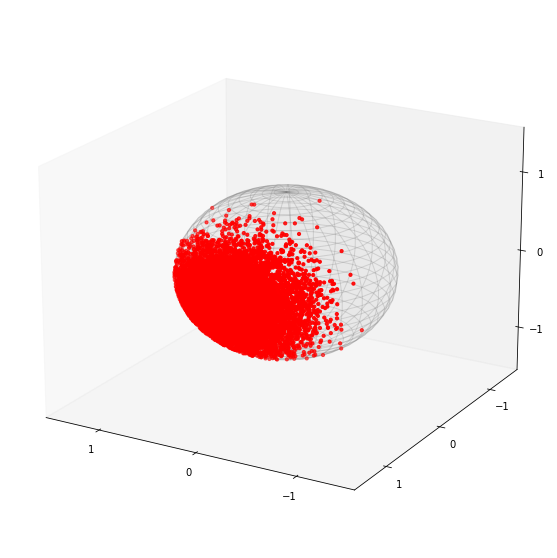

In [5]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
plot_3d_scatter(X_target.detach().cpu().numpy(), ax)
ax.view_init(20,120)
plt.show()

~/Sphere/SW_Sphere/./lib/utils_sphere.py:63: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(tt, pp, heatmap, cmap=plt.cm.jet)


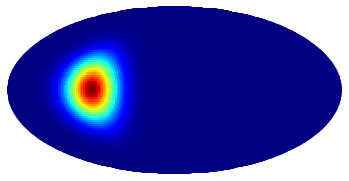

In [6]:
target_fn = lambda x : pdf_vmf(torch.tensor(x, dtype=torch.float, device=device), 
                               torch.tensor([mu_target], dtype=torch.float, device=device), 
                               kappa_target).cpu().numpy()

plot_target_density(target_fn)

~/Sphere/SW_Sphere/./lib/utils_sphere.py:95: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(tt, pp, heatmap, cmap=plt.cm.jet,vmax=vmax)


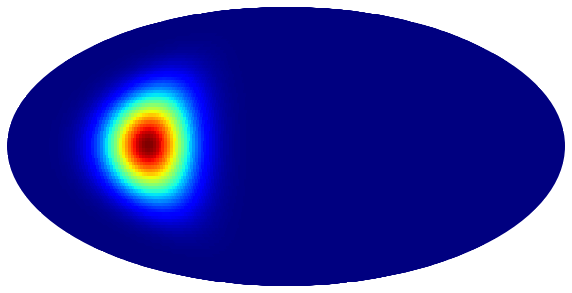

In [7]:
target_fn = lambda x : pdf_vmf(torch.tensor(x, dtype=torch.float, device=device), 
                               torch.tensor([mu_target], dtype=torch.float, device=device), 
                               kappa_target).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(10,10), subplot_kw={'projection': "mollweide"})
projection_mollweide(target_fn, ax)
plt.show()

~/Sphere/SW_Sphere/./lib/utils_sphere.py:84: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(tt, pp, heatmap, cmap=plt.cm.jet)


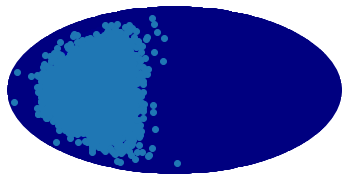

In [8]:
scatter_mollweide(X_target, target_fn)

### Gradient Descent on Particles

In [9]:
X0 = torch.randn((500, 3), device=device)
X0 = F.normalize(X0, p=2, dim=-1)
X0.requires_grad_(True)

L = [X0.clone()]
L_loss = []

n_steps = 1001
num_projections = 1000
lr = 100

pbar = trange(n_steps)

for k in pbar:
    X_target = next(dataiter).type(torch.float).to(device)
    
    sw = sliced_wasserstein_sphere(X_target, X0, num_projections, device, p=2)
    grad_x0 = torch.autograd.grad(sw, X0)[0]

    X0 = X0 - lr * grad_x0
    X0 = F.normalize(X0, p=2, dim=1)
    
    if torch.any(torch.isnan(grad_x0)):
        print(grad_x0)
    
    L_loss.append(sw.item())
    L.append(X0.clone().detach())
    pbar.set_postfix_str(f"loss = {sw.item():.3f}")

  0%|          | 0/1001 [00:00<?, ?it/s]

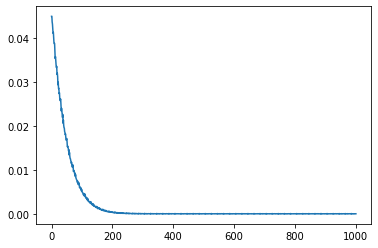

In [10]:
plt.plot(L_loss)
plt.show()

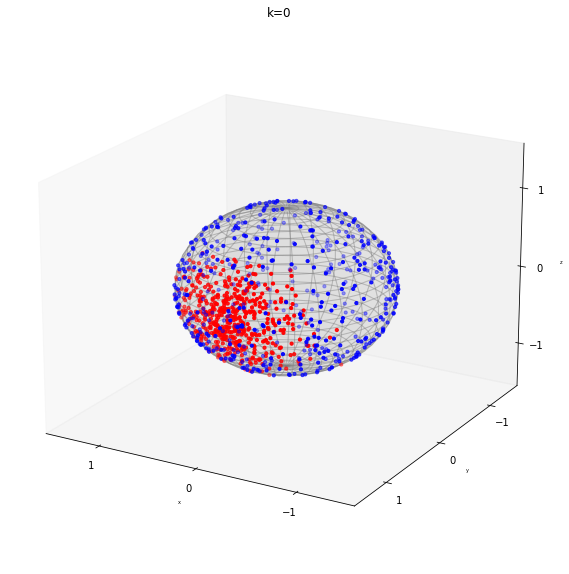

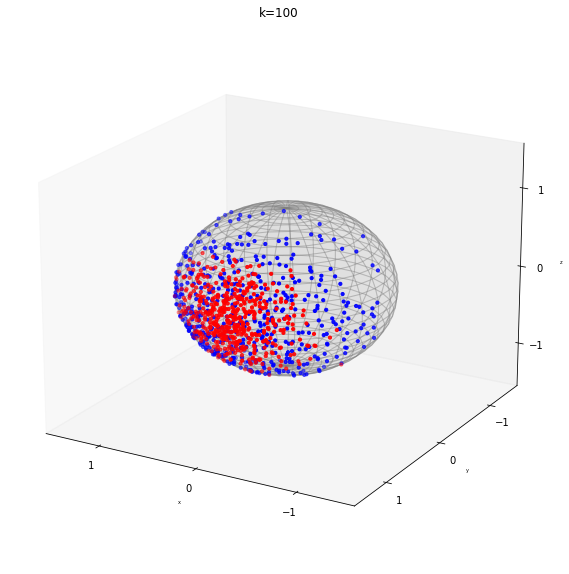

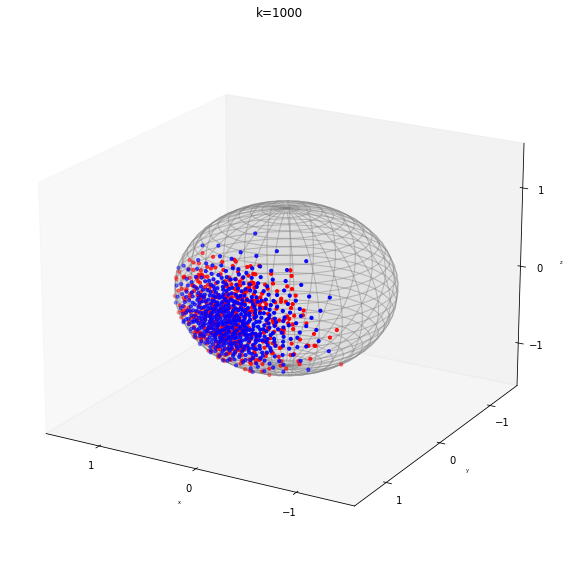

In [11]:
for k in [0,100,1000]:
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    
    plot_3d_scatter(X_target.detach().cpu().numpy(), ax)
    plot_3d_scatter(L[k].detach().cpu().numpy(), ax, colour='blue')

    fs = 5
    # Labels 
    ax.set_xlabel('x',fontsize=fs)
    ax.set_ylabel('y',fontsize=fs)
    ax.set_zlabel('z',fontsize=fs)

    # Viewing angle
    ax.view_init(20,120)
    ax.set_title("k="+str(k))
    plt.show()

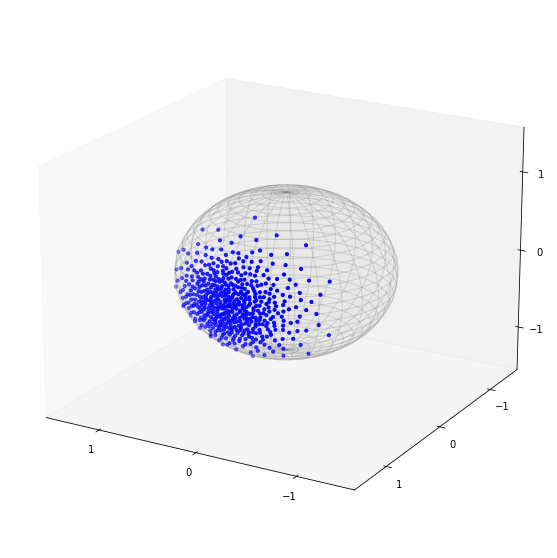

In [12]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
plot_3d_scatter(L[-1].detach().cpu().numpy(), ax, colour='blue')
ax.view_init(20,120)
plt.show()

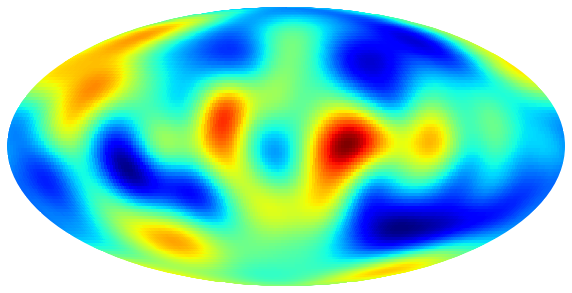

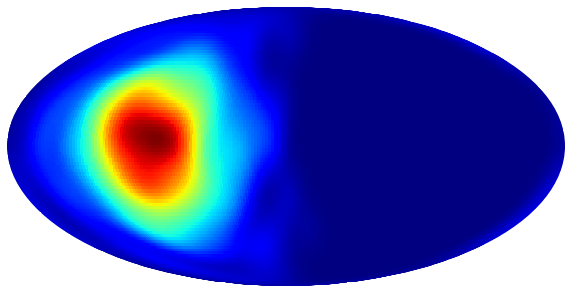

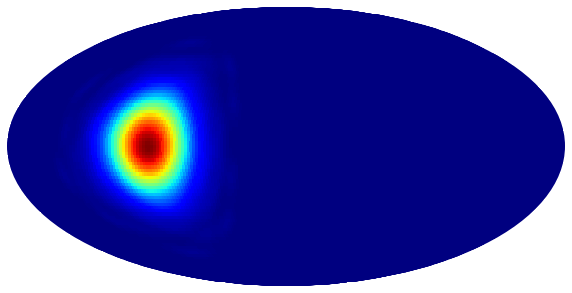

In [13]:
for i in [0,100,1000]:
    kernel = gaussian_kde(L[i].T.detach().cpu())
    
    fig, ax = plt.subplots(1, 1, figsize=(10,10), subplot_kw={'projection': "mollweide"})
    projection_mollweide(lambda x: kernel.pdf(x.T), ax)
    plt.show()

### Gradient Descent on the Sphere

Gradient descent on the sphere:
\begin{equation}
    x_{k+1} = \exp_{x_k}(-\gamma_k \nabla_{S^{d-1}}\mathcal{F}(x_k)),
\end{equation}
where $\exp_x(v)=x\cos(\|v\|) + \frac{v}{\|v\|}\sin(\|v\|)$ and $\mathrm{grad} f(x) = \mathrm{Proj}_x(\nabla f(x)) = \nabla f(x) - \langle x,\nabla f(x)\rangle x$ (projection on the orthogonal space).

See e.g. Chapter 3 of [1] or p27 of [2].

[1] Absil, P-A., Robert Mahony, and Rodolphe Sepulchre. Optimization algorithms on matrix manifolds. Princeton University Press, 2009.

[2] Boumal, Nicolas, Pierre-Antoine Absil, and Coralia Cartis. "Global rates of convergence for nonconvex optimization on manifolds." IMA Journal of Numerical Analysis 39.1 (2019): 1-33.

In [14]:
X0 = torch.randn((500, 3), device=device)
X0 = F.normalize(X0, p=2, dim=-1)
X0.requires_grad_(True)

L = [X0.clone()]
L_loss = []

n_steps = 1001
num_projections = 1000
lr = 100

pbar = trange(n_steps)

for k in pbar:
    X_target = next(dataiter).type(torch.float).to(device)
    
    sw = sliced_wasserstein_sphere(X_target, X0, num_projections, device, p=2)
    grad_x0 = torch.autograd.grad(sw, X0)[0]
    grad_S = grad_x0 - torch.sum(X0*grad_x0, dim=-1)[:,None]*X0
    v = -lr*grad_S
    norm_v = torch.linalg.norm(v, axis=-1)[:,None]
    
    X0 = X0*torch.cos(norm_v) + torch.sin(norm_v) * v/norm_v
        
    L_loss.append(sw.item())
    L.append(X0.clone().detach())
    pbar.set_postfix_str(f"loss = {sw.item():.3f}")

  0%|          | 0/1001 [00:00<?, ?it/s]

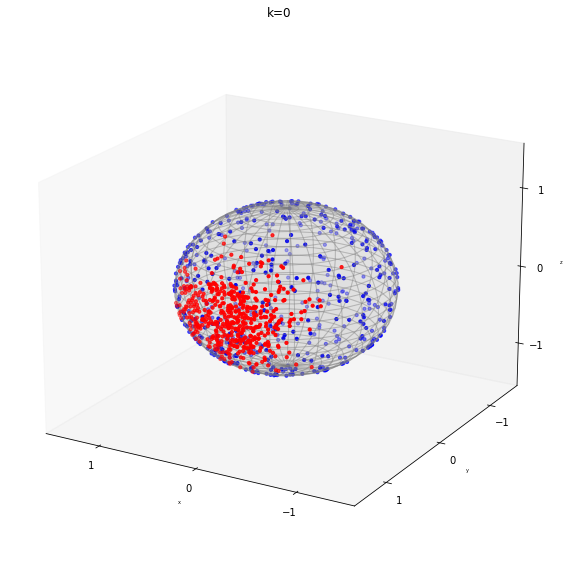

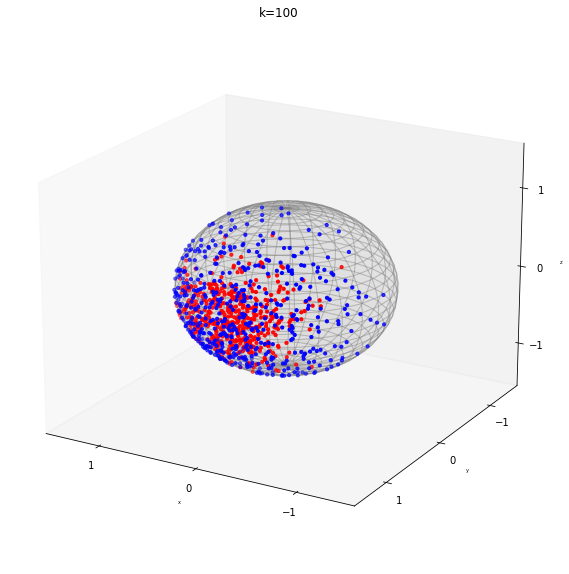

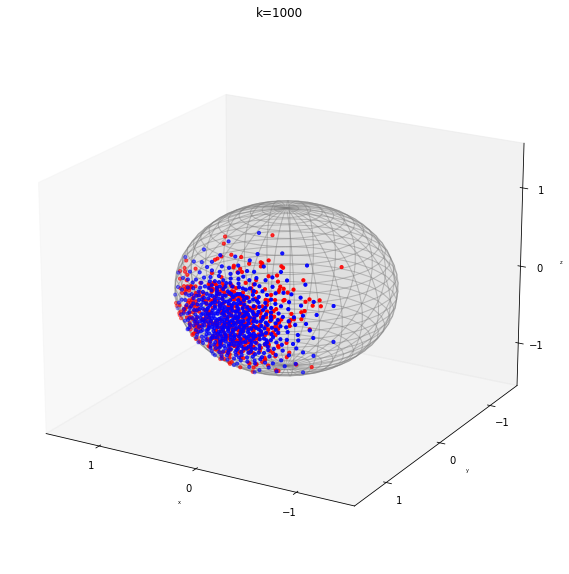

In [15]:
for k in [0,100,1000]:
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    
    plot_3d_scatter(X_target.detach().cpu().numpy(), ax)
    plot_3d_scatter(L[k].detach().cpu().numpy(), ax, colour='blue')

    fs = 5
    # Labels 
    ax.set_xlabel('x',fontsize=fs)
    ax.set_ylabel('y',fontsize=fs)
    ax.set_zlabel('z',fontsize=fs)

    # Viewing angle
    ax.view_init(20,120)
    ax.set_title("k="+str(k))
    plt.show()

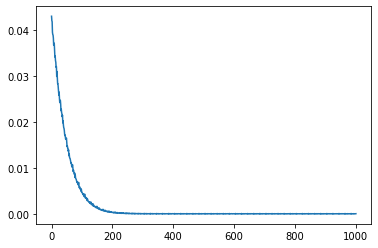

In [16]:
plt.plot(L_loss)
plt.show()

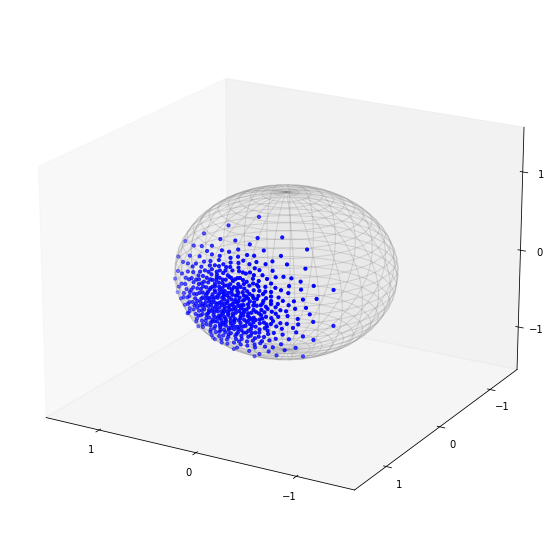

In [17]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
plot_3d_scatter(L[-1].detach().cpu().numpy(), ax, colour='blue')
ax.view_init(20,120)
plt.show()

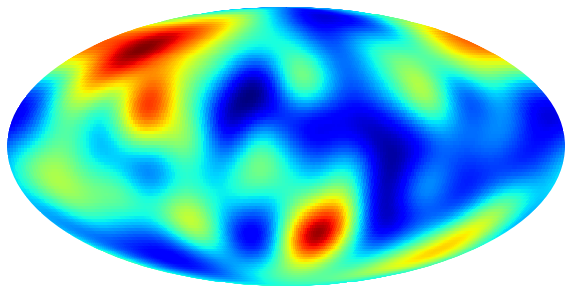

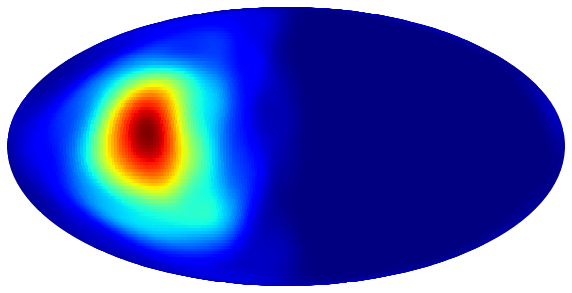

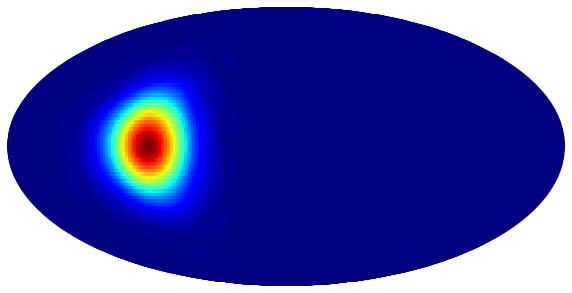

In [18]:
for i in [0,100,1000]:
    kernel = gaussian_kde(L[i].T.detach().cpu())
    
    fig, ax = plt.subplots(1, 1, figsize=(10,10), subplot_kw={'projection': "mollweide"})
    projection_mollweide(lambda x: kernel.pdf(x.T), ax)
    plt.show()

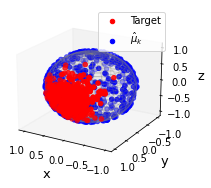

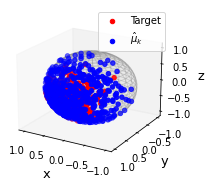

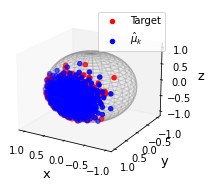

In [19]:
for k in [0,100,1000]:
    fig = plt.figure(figsize=(4,3))
    ax = plt.axes(projection='3d')
    ax.grid(False)

    u, v = np.mgrid[0:2*np.pi:30j, 0:np.pi:30j]
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)
    ax.plot_surface(x, y, z, color="gray",alpha=0.03)
    ax.plot_wireframe(x, y, z, linewidth=1, alpha=0.25, color="gray")
    
    xx = X_target.detach().cpu().numpy()
    ax.scatter(xx[:,0], xx[:,1], xx[:,2], c="red", label="Target")
    yy = L[k].detach().cpu().numpy()
    ax.scatter(yy[:,0], yy[:,1], yy[:,2], c='blue', label=r"$\hat{\mu}_k$")

    fs = 13
    # Labels 
    ax.set_xlabel('x',fontsize=fs)
    ax.set_ylabel('y',fontsize=fs)
    ax.set_zlabel('z',fontsize=fs)

    # Viewing angle
    ax.view_init(20,120)
    plt.legend() #fontsize=fs)
    plt.show()

## With NFs

### Learning Sampling

  0%|          | 0/2001 [00:00<?, ?it/s]

k=0


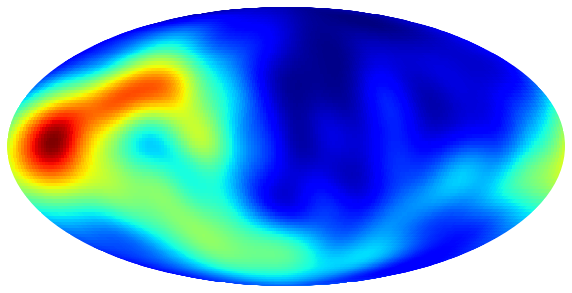

k=100


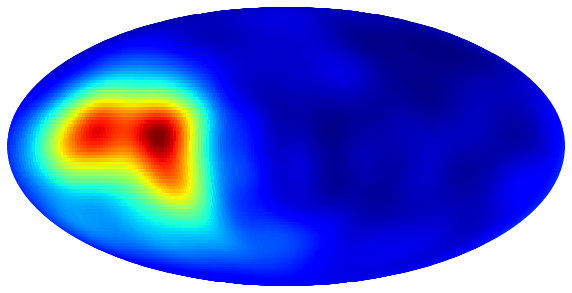

k=200


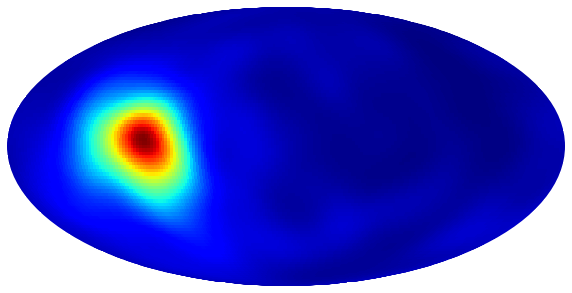

k=300


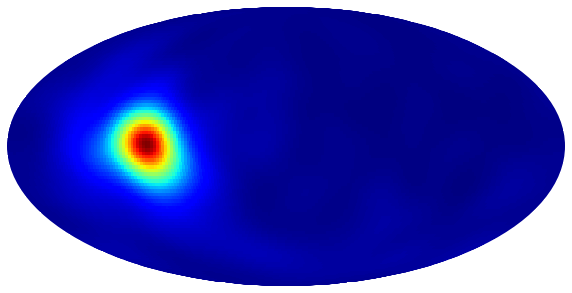

k=400


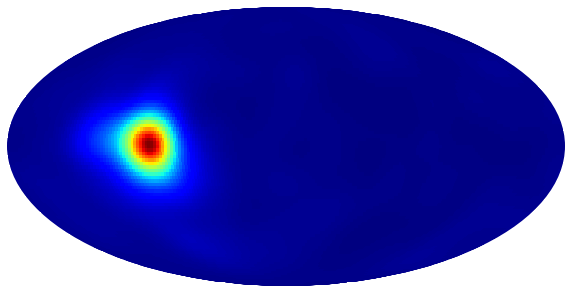

k=500


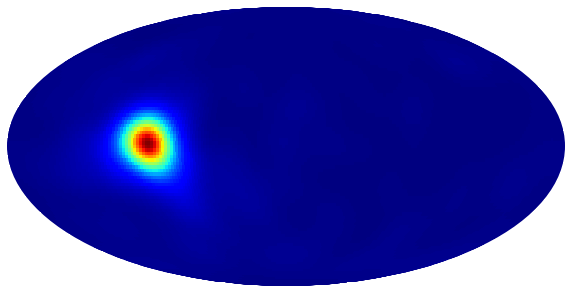

k=600


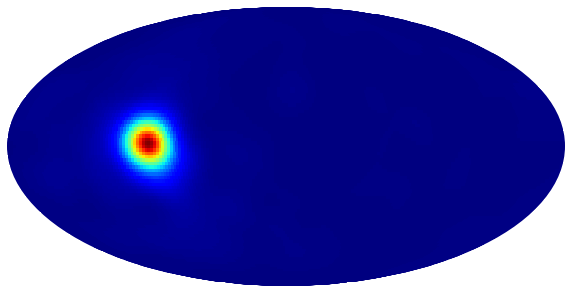

k=700


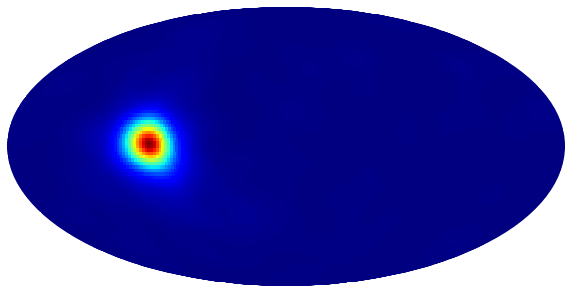

k=800


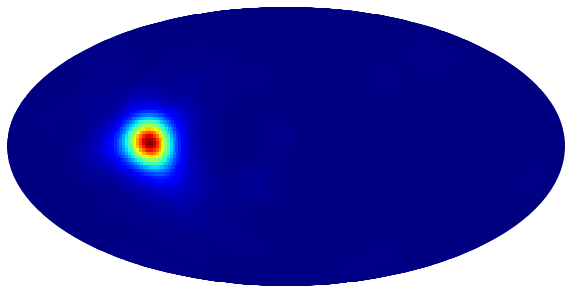

k=900


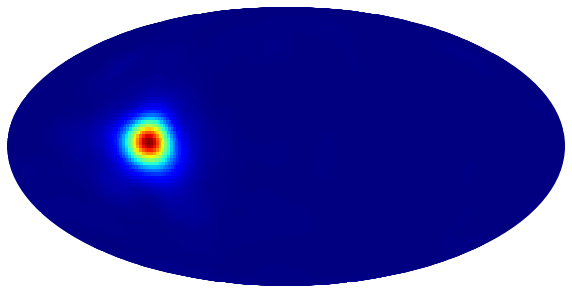

k=1000


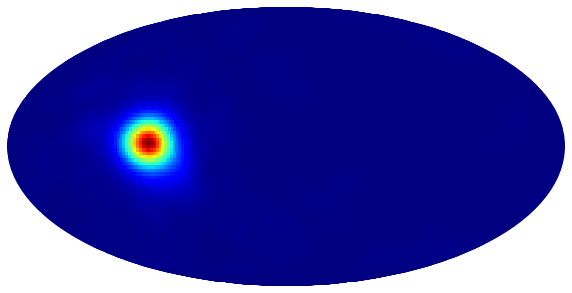

k=1100


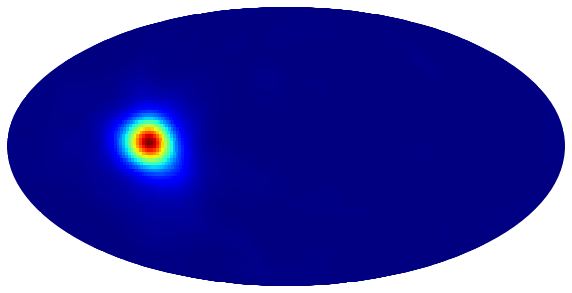

k=1200


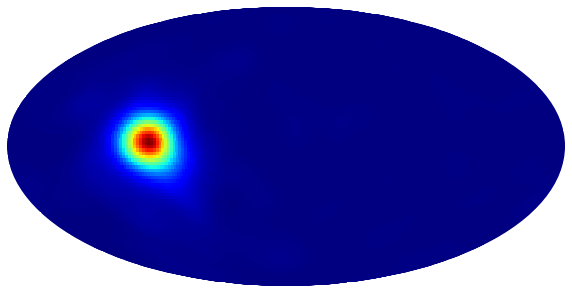

k=1300


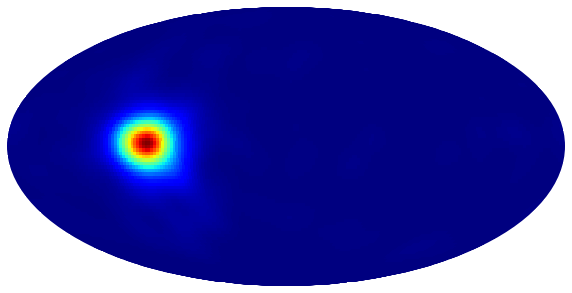

k=1400


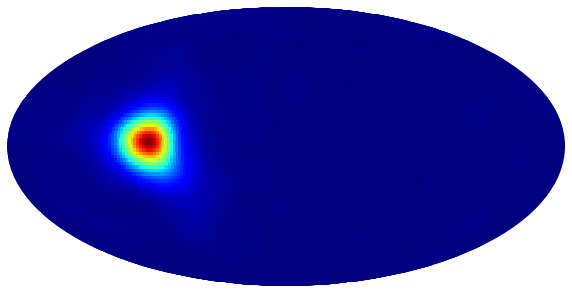

k=1500


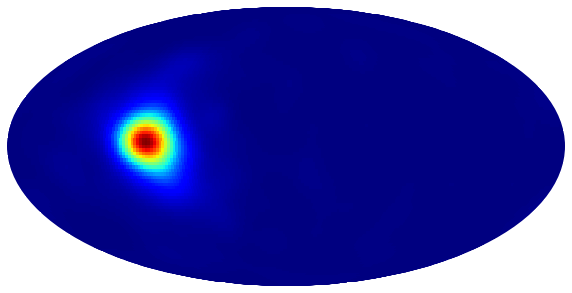

k=1600


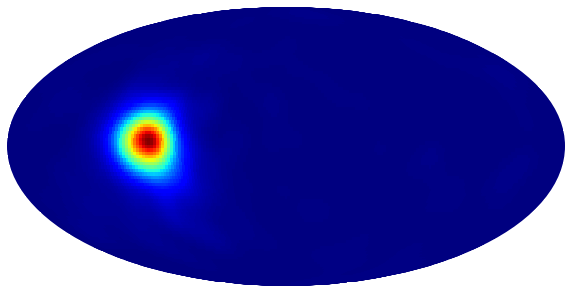

k=1700


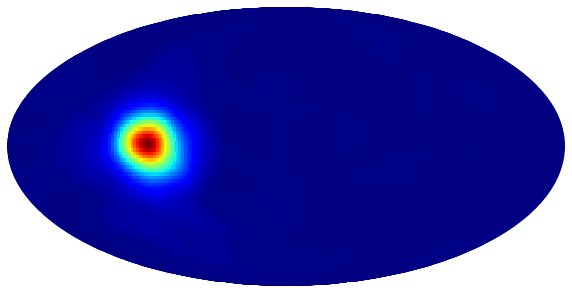

k=1800


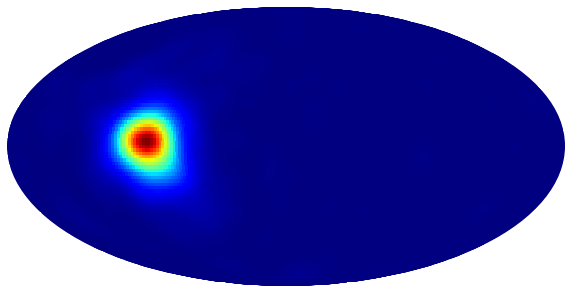

k=1900


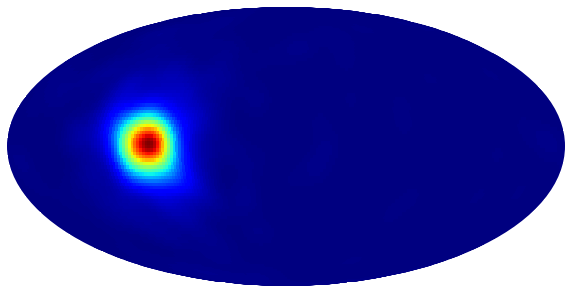

k=2000


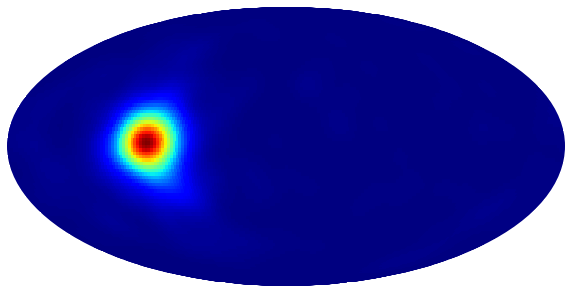

In [34]:
model = create_NF().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

n_steps = 2001
num_projections = 1000
batch_size = 500

L_loss = []

pbar = trange(n_steps)

for k in pbar:
    X_target = next(dataiter).type(torch.float).to(device)
    
    z = F.normalize(torch.randn(batch_size, 3, device=device), p=2, dim=-1)
    x, _ = model(z)
    
    sw = sliced_wasserstein_sphere(x[-1], X_target, num_projections, device, p=2)
    sw.backward()
    optimizer.step()
    
    optimizer.zero_grad()
    
    pbar.set_postfix_str(f"loss = {sw.item():.3f}")
    L_loss.append(sw.item())
    

    if k%100 == 0:
        print("k="+str(k))
        
        noise = F.normalize(torch.randn((1000,3), device=device), p=2, dim=-1)
        z0, _ = model(noise)        
        
        kernel = gaussian_kde(z0[-1].T.detach().cpu())
    
        fig, ax = plt.subplots(1, 1, figsize=(10,10), subplot_kw={'projection': "mollweide"})
        projection_mollweide(lambda x: kernel.pdf(x.T), ax)
        plt.show()

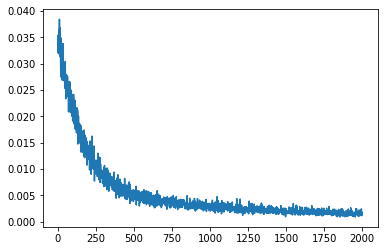

In [35]:
plt.plot(L_loss)
plt.show()

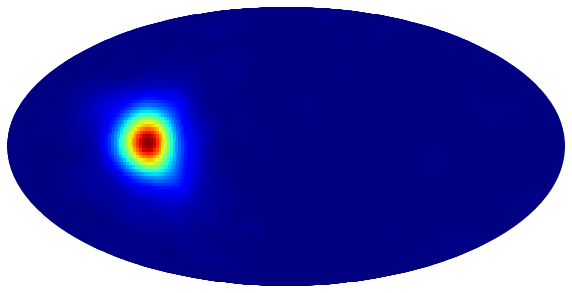

In [36]:
## Gaussian KDE as in "NF on Tori and Spheres"
noise = F.normalize(torch.randn((1000,3), device=device), p=2, dim=-1)
z0, _ = model(noise)

kernel = gaussian_kde(z0[-1].T.detach().cpu())

fig, ax = plt.subplots(1, 1, figsize=(10,10), subplot_kw={'projection': "mollweide"})
projection_mollweide(lambda x: kernel.pdf(x.T), ax)
plt.show()

### Learning density

In [37]:
def log_likelihood(h, log_det):
    prior = np.log(1 / (4 * np.pi)) * torch.ones(h.shape[0], device=device)
    return (prior+log_det)

  0%|          | 0/2001 [00:00<?, ?it/s]

k=0


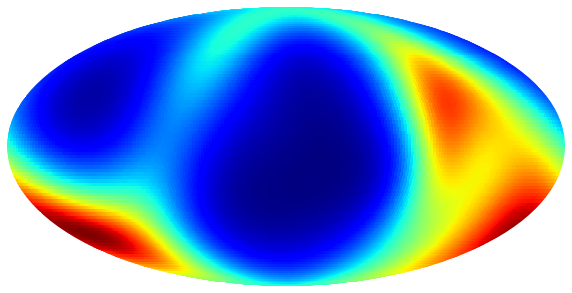

k=100


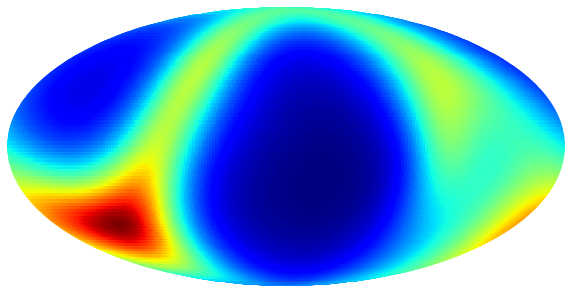

k=200


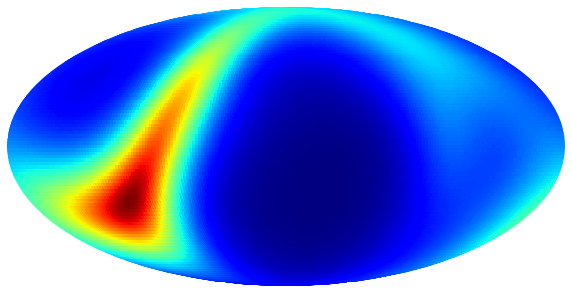

k=300


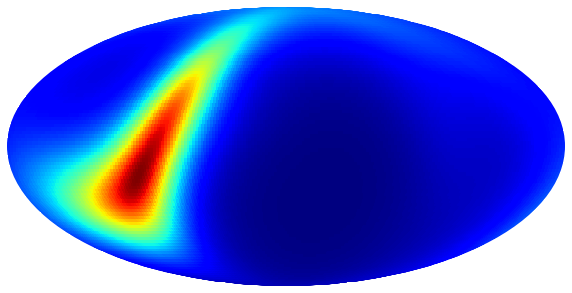

k=400


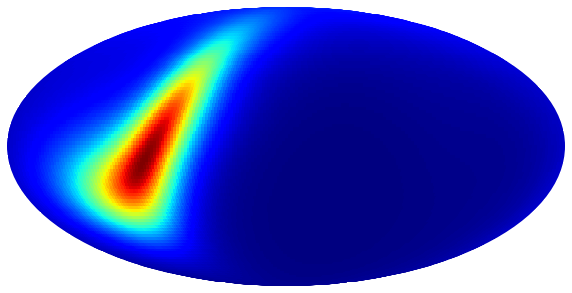

k=500


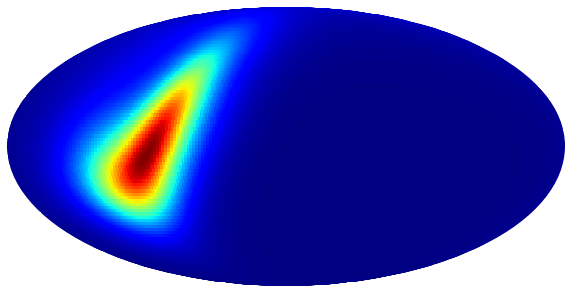

k=600


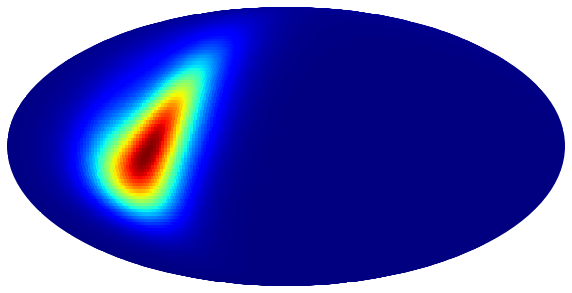

k=700


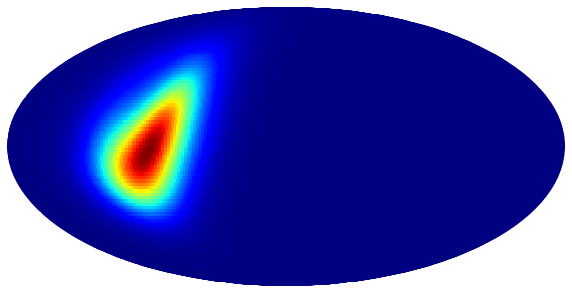

k=800


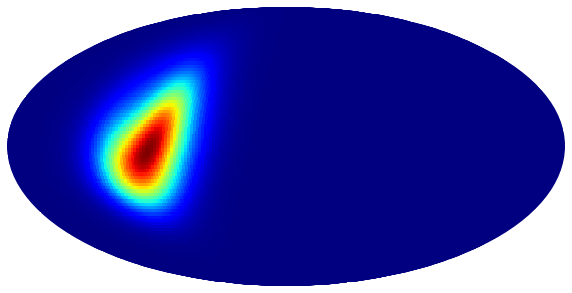

k=900


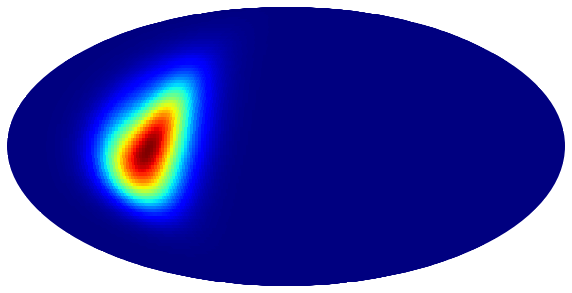

k=1000


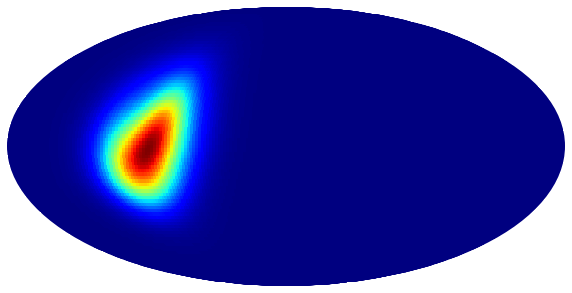

k=1100


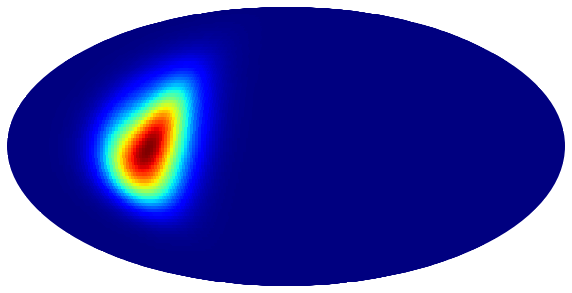

k=1200


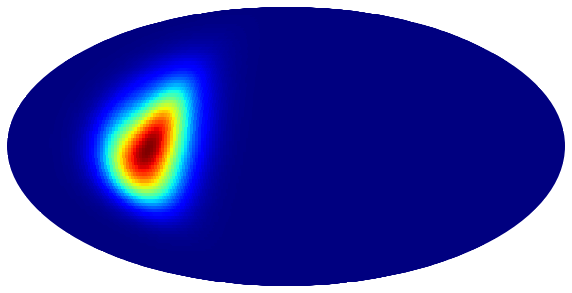

k=1300


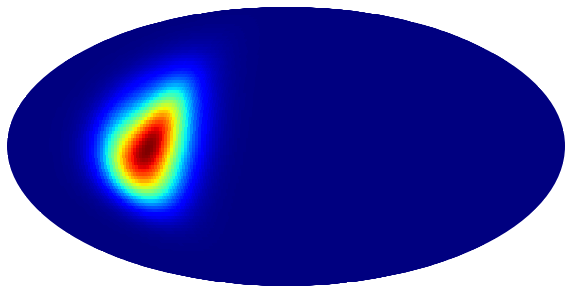

k=1400


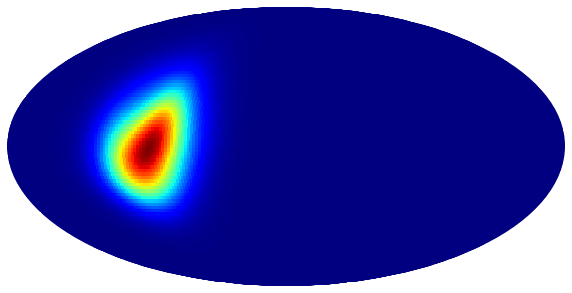

k=1500


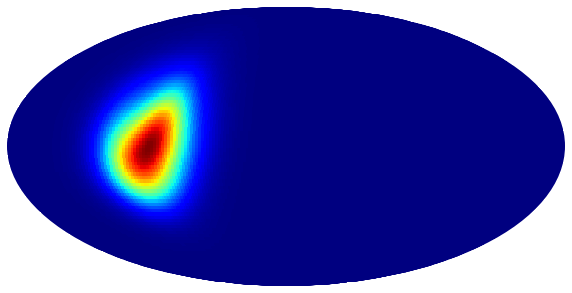

k=1600


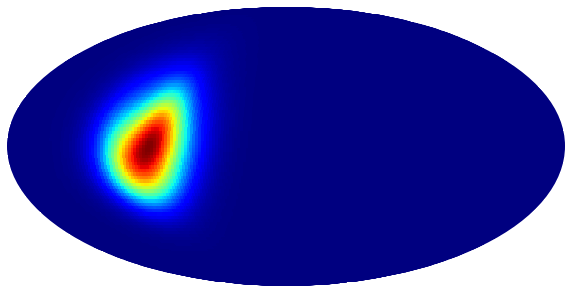

k=1700


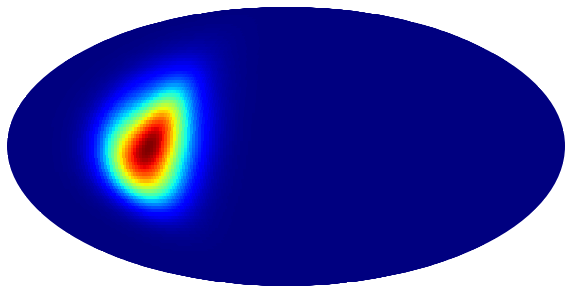

k=1800


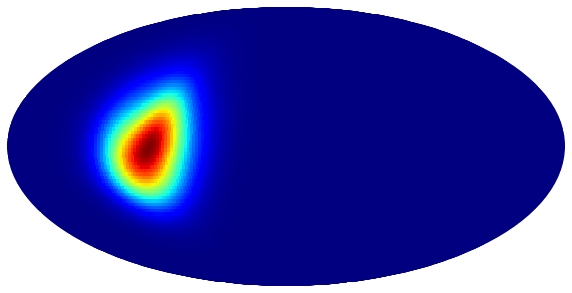

k=1900


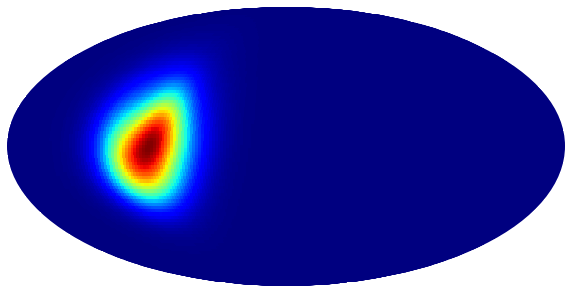

k=2000


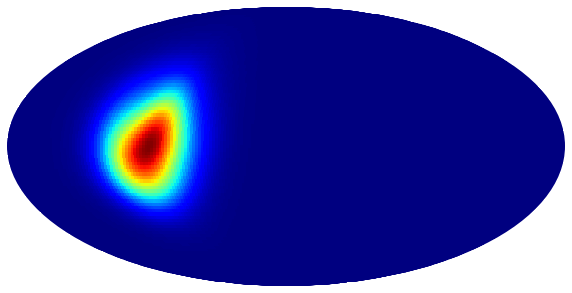

In [38]:
model = create_NF().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

n_steps = 2001
num_projections = 1000
batch_size = 500

L_loss = []

pbar = trange(n_steps)

for k in pbar:
    X_target = next(dataiter).type(torch.float).to(device)
    x, _ = model(X_target)
    
    z = F.normalize(torch.randn(batch_size, 3, device=device), p=2, dim=-1)
    
    sw = sliced_wasserstein_sphere(x[-1], z, num_projections, device, p=2)
    sw.backward()
    optimizer.step()
    
    optimizer.zero_grad()
    
    pbar.set_postfix_str(f"loss = {sw.item():.3f}")
    L_loss.append(sw.item())
    

    if k%100 == 0:
        print("k="+str(k))
        
        theta = np.linspace(0, 2 * np.pi, 2 * 100)
        phi = np.linspace(0, np.pi, 100)
        tp = np.array(np.meshgrid(theta, phi, indexing='ij'))
        tp = tp.transpose([1, 2, 0]).reshape(-1, 2)
        tp = spherical_to_euclidean_torch(torch.tensor(tp, device=device, dtype=torch.float))
        
        z, log_det = model(tp)
                
        fig, ax = plt.subplots(1, 1, figsize=(10,10), subplot_kw={'projection': "mollweide"})
        projection_mollweide(lambda x: log_likelihood(z[-1], log_det).exp().detach().cpu(), ax)
        plt.show()

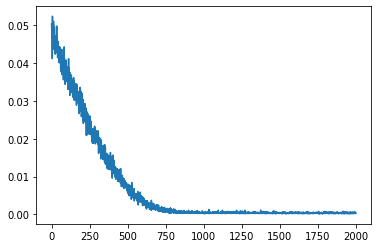

In [39]:
plt.plot(L_loss)
plt.show()

## Mixture of vMF

In [40]:
ps = np.ones(6)/6
mus = torch.tensor([[1,0,0],[0,1,0],[0,0,1],[-1,0,0],[0,-1,0],[0,0,-1]], dtype=torch.float)
mus = F.normalize(mus, p=2, dim=-1)

# mus = spherical_to_euclidean(np.array([
#     [1.5, 0.7 + np.pi / 2],
#     [1., -1. + np.pi / 2],
#     [5., 0.6 + np.pi / 2],  # 0.5 -> 5.!
#     [4., -0.7 + np.pi / 2]
# ]))
# mus = torch.tensor(mus, dtype=torch.float)

Z = np.random.multinomial(10000,ps)
X = []
for k in range(len(Z)):
    if Z[k]>0:
        vmf = rand_von_mises_fisher(mus[k], kappa=10, N=int(Z[k]))
        X += list(vmf)

X_target = torch.tensor(X, device=device, dtype=torch.float)

train_dl = DataLoader(X_target, batch_size=500, shuffle=True)
dataiter = iter(cycle(train_dl))

In [41]:
def target_density(x):
    m = torch.matmul(x, mus.T)
    return torch.sum(torch.exp(10 * m), dim=-1)

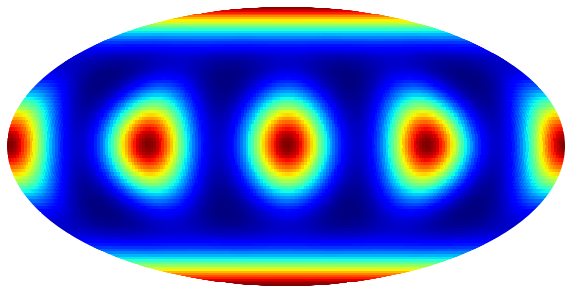

In [42]:
V = lambda x: -torch.log(target_density(x))
target = lambda x : np.exp(-V(torch.tensor(x, dtype=torch.float)).cpu().numpy())

fig, ax = plt.subplots(1, 1, figsize=(10,10), subplot_kw={'projection': "mollweide"})
projection_mollweide(target, ax)
plt.show()

- Gradient Descent on Particles

In [52]:
X0 = torch.randn((500, 3), device=device)
X0 = F.normalize(X0, p=2, dim=-1)
X0.requires_grad_(True)

L = [X0.clone()]
L_loss = []

n_steps = 1001
num_projections = 1000
lr = 100

pbar = trange(n_steps)

for k in pbar:
    X_target = next(dataiter).type(torch.float).to(device)
    
    sw = sliced_wasserstein_sphere(X_target, X0, num_projections, device, p=2)
    grad_x0 = torch.autograd.grad(sw, X0)[0]

    X0 = X0 - lr * grad_x0
    X0 = F.normalize(X0, p=2, dim=1)
    
    if torch.any(torch.isnan(grad_x0)):
        print(grad_x0)
    
    L_loss.append(sw.item())
    L.append(X0.clone().detach())
    pbar.set_postfix_str(f"loss = {sw.item():.3f}")

  0%|          | 0/1001 [00:00<?, ?it/s]

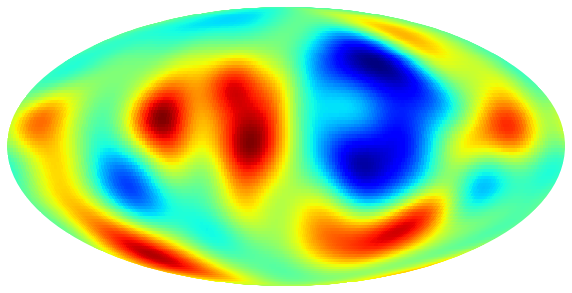

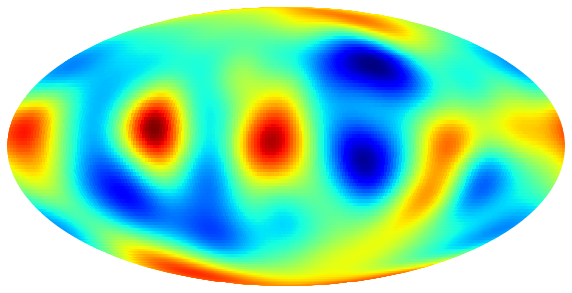

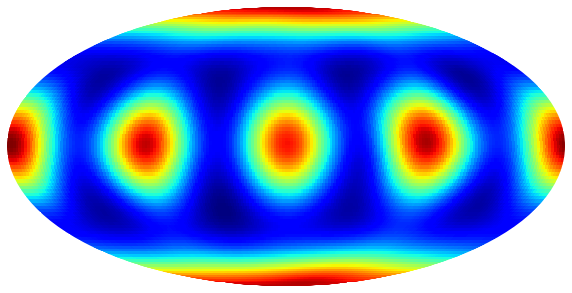

In [56]:
for i in [0,100,1000]:
    kernel = gaussian_kde(L[i].T.detach().cpu())
    
    fig, ax = plt.subplots(1, 1, figsize=(10,10), subplot_kw={'projection': "mollweide"})
    projection_mollweide(lambda x: kernel.pdf(x.T), ax)
    plt.show()